In [12]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from utils.funs import scores

from transformers import AutoModelForCausalLM

In [13]:
def getscoresMistral(d,l,h,h_kv,dh,model):
    """
    Let Q and K be
    Q = X @ W_q ; K = X @ W_k

    it follows that the dot product between queries and keys is 
    Q @ K^T = X @ (W_q @ W_k^T) @ X^T = X @ M @ X^T 

    where M is a square matrix \in R^{d,d}, that can be decomposed into its
    symmetric and skew-symmetric part S and N, respectively,
    M = 1/2 * (M + M^T) + 1/2 * (M - M^T) = S + N

    important: nn.Linear.weight returns the learnable weights of the module as
    (out_features,in_features), then we can access the matrix W_q or 
    W_k as nn.Linear.weight^T

    Args:
        - d (int) : embeddding dimension.
        - l (int) : total number of layers
        - h (int) : number of heads.
        - dh (int) : embedding dimension per head.
        - model () : full model.

    Returns:
        - SList (numpy ndarray) : List of Symmetric (S) scores.
        - NList (numpy ndarray) : List of Skew-symmetric (N) scores.
    """

    SList = np.zeros((l,h))
    NList = np.zeros((l,h))
    
    # retrieve all BertLayer instances (the encoder in each layer)
    layers = model.model.layers

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.self_attn

        # access W_q and W_k: transpose the weight matrix and split into heads
        Wv = self_attention.v_proj._parameters["weight"].T.view(d,h_kv,dh).detach().numpy()
        # GQA (grouped-query-attention) defines multiple key and value heads for the same query
        Wo = self_attention.o_proj._parameters["weight"].view(d,h,dh).T.detach().numpy()

        gqa_count = 0
        for j in range(h):
            
            if j % (h // h_kv) == 0 and j != 0 :
                gqa_count += 1
            # calculate the association matrix M
            M = Wv[:,gqa_count,:] @ Wo[:,j,:]
            # compute symmetry and skew-symmetry scores
            S, N = scores(M)
            SList[i,j], NList[i,j] = S, N

    return  SList, NList

In [17]:
"""
- KEY (str): model name
- VALUES (list): [layers (int), 
                  embedding dim (int), 
                  heads (int), 
                  head dim (int), 
                  S scores, 
                  N scores]
"""

if os.path.isfile('../../_data/fig_scores/Mistral-value-out.pkl'):
    with open('../../_data/fig_scores/Mistral-value-out.pkl', 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [4]:
'Mistral model 7b (l = 32, d = 4096, h = 32, h_kv = 8 ; tot num parameters 7B)'
dh = 128
l = 32
d = 4096
h = 32
h_kv = 8
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")
S, N = getscoresMistral(d,l,h,h_kv,dh,model)
models['Mistral7b'] = [l,d,h,h_kv,dh,S,N]

print('done')
'Mistral model 7b instruct v0.1 (l = 32, d = 4096, h = 32, h_kv = 8 ; tot num parameters 7B)'
dh = 128
l = 32
d = 4096
h = 32
h_kv = 8
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
S, N = getscoresMistral(d,l,h,h_kv,dh,model)
models['Mistral7b-instructv0.1'] = [l,d,h,h_kv,dh,S,N]

print('done')
'Mistral model 7b instruct v0.2 (l = 32, d = 4096, h = 32, h_kv = 8 ; tot num parameters 7B)'
dh = 128
l = 32
d = 4096
h = 32
h_kv = 8
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
S, N = getscoresMistral(d,l,h,h_kv,dh,model)
models['Mistral7b-instructv0.2'] = [l,d,h,h_kv,dh,S,N]

Loading checkpoint shards: 100%|██████████| 2/2 [00:22<00:00, 11.35s/it]
/var/folders/yy/3fh2plpd0txg1y9llct3rsv80000gn/T/ipykernel_4328/22831712.py:43: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_5ae0635zuj/croot/pytorch-select_1700511177724/work/aten/src/ATen/native/TensorShape.cpp:3618.)
  Wo = self_attention.o_proj._parameters["weight"].view(d,h,dh).T.detach().numpy()


done


Loading checkpoint shards: 100%|██████████| 2/2 [00:38<00:00, 19.45s/it]


done


Loading checkpoint shards: 100%|██████████| 3/3 [00:31<00:00, 10.49s/it]


In [18]:
'save'
with open('../../_data/fig_scores/Mistral-value-out.pkl', 'wb') as file:
    pickle.dump(models, file)

(0.0, 1.0)

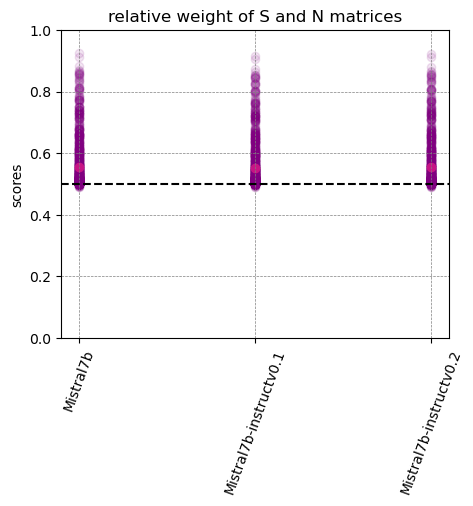

In [19]:
import matplotlib.pyplot as plt

with open('../../_data/fig_scores/Mistral-value-out.pkl', 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-2].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(5,4))

for i, model in enumerate(SList):
    
    plt.scatter(i*np.ones(SList[i].size),(SList[i].flatten()**2),color='purple',alpha=.1)
    plt.scatter(i,(SList[i].flatten()**2).mean(),color='mediumvioletred')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight of S and N matrices')
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=70)
plt.axhline(y=.5,color='k',linestyle='dashed')
plt.ylim(0,1)